## Projekt - Chemisches Rauschen

Chemische Reaktionen finden zwischen einzelnen Teilchen statt. Die Anzahl verschiedener
Teilchen in einem System ist hierbei aus der Menge der natuerlichen Zahlen. Wird ein Teilchen
umgewandelt verringert sich die Anzahl der entsprechenden Teilchensorte und die Anzahl
der Teilchen des Reaktionsproduktes erhoeht sich. Die Zeitpunkte an denen diese Uebergaenge
stattfinden sind zufaellig. Nichtsdestotrotz werden chemische Reaktionen oft sehr genau durch
Differentialgleichungen fuer die Konzentrationen der Stoffe beschrieben. In diesem Projekt
sollen der Gillespie Algorithmus zur stochastischen Simulation von chemischen Reaktionen
erarbeitet, und einige der Simulationen in den urspruenglichen Artikeln [1, 2] nachvollzogen
werden. 

Belesen Sie sich zunaechst zu den Themen *chemische Kinetik*, *Gillespie Algorithmus*,
*Exponential-* und *Gammaverteilung* und schauen Sie sich die Artikel [1, 2] an!

### Aufgaben

#### Beispiel 1 : Radioaktiver Zerfall

Als erstes wollen wir radioaktiven Zerfall der Form

$$
R_0 : A \to B
$$

betrachten. 
- Wie lautet die Differentialgleichung fuer die Konzentration $a = N_A/V$ des radioaktiven
Stoffes $A$? Wie lautet die Loesung dieser Differentialgleichung? 

Die Differentialgleichung lautet $$\frac{da_A}{dt}=-k_0 \cdot a_A$$ 

- Wie groß ist die Uebergangsrate $r_0(N_A,k_0,V)$? 

Die Übergangsrate berechnet sich durch $$r_0 = k_0 \cdot N_A \cdot V$$
- Simulieren Sie den zufaelligen radioaktiven Zerfall fuer verschiedene Anfangswerte $N_A(t = 0) \in \{10^1, 10^2, \dots , 10^6\}$ mehrmals und ploten Sie fuer jedes $N_A(0)$ den Anteil $N_A(t)/N_A(0)$ der nicht zerfallenen Teilchen als Funktion der Zeit. 
- Vergleichen Sie diese Simulationsdaten mit der Loesung $a(t)/a(0)$ der Differentialgleichung (z.B. im selben Plot).

**Zusatzaufgabe:** 
- Bestimmen Sie die mittlere Zeit $T_{stop}$, die das System braucht, bis alle
Teilchen zerfallen sind, und die Varianz $\sigma_{stop}^2$ dieser Zeit. Welcher Zusammenhang existiert
zwischen den Groessen $T_{stop}$, $\sigma_{stop}^2$ und $N_A(0)$? 

*Hinweis:* $T_{stop}$ ist der Maximalwert aus $N_A(0)$ identisch und unabhaengig, exponentiell verteilten Zufallsvariablen.

In [1]:
import numpy as np
%matplotlib inline
from pylab import *

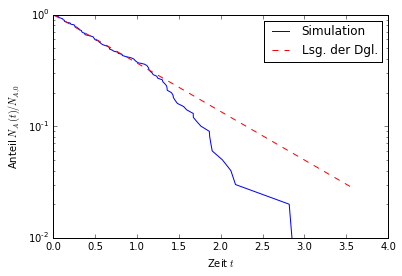

In [85]:
V = 1
nA0 = 100
nB0 = 0
n0 = np.array([nA0, nB0])
nu0 = np.array([-1, +1])
nu = [nu0]
k0 = 1
k = [k0]
t_max = 1000

def calculate_r(n, k, V):
    r0 = V * n[0] * k[0]
    r = [r0]
    return r

def reaction(V, n0, nu, k, t_max):
    t = 0
    n = n0

    while n[0]>0:
        r = calculate_r(n, k, V)
        r_tot = sum(r)
        if r_tot==0:
            break
        dt = np.random.exponential(scale = 1/r_tot)
        t = t+dt
        i = np.random.rand()
        i = np.argmax(i<np.cumsum(r)/r_tot)
        n = n + nu[i]
        yield t, n
        
t, n = zip(*list(reaction(V, n0, nu, k, t_max)))
n = np.array(n).T
t = np.array(t)
semilogy(t,n[0]/n0[0], label="Simulation")
semilogy(t,(nA0 * exp(-k0 * t))/n0[0], 'r--', label="Lsg. der Dgl.")
legend(loc=0)
xlabel("Zeit $t$")
ylabel("Anteil $N_A(t)/N_{A, 0}$")
#savefig('A1n10000.pdf')

In [14]:
print(nu[1])

[ 1 -1]


In [121]:
i = 0.4
example = np.array([1,2,3])
np.argmax(i < np.cumsum(example)/np.sum(example))
np.cumsum(example)/np.sum(example)

array([ 0.16666667,  0.5       ,  1.        ])

#### Beispiel 2 : Brusselator

Als naechstes soll eine Reaktion mit dynamischer Instabilitaet untersucht werden, das sogenannte
Brusselatormodell. Dieses wird durch die folgenden Reaktionen beschrieben :

$$
\begin{eqnarray}
R_0 &:& X_0 \to X_0 + Y_0 \\
R_1 &:& X_1 \to X_1 + Y_1 + Z_0 \\
R_2 &:& 2Y_0 + Y_1 \to 3Y_0\\
R_3 &:& Y_0 \to Z_1
\end{eqnarray}
$$

Teilchen der Sorte $X_i$ bilden die Resourcen der chemischen Reaktion. Da die Resourcen
waehrend der Reaktion konstant gehalten werden sollen, haben wir die rechten Seiten der
Reaktionen $R_0$ und $R_1$ einfach ergaenzt. In Reaktion $R_0$ bedeutet dies z.B., dass jedesmal
wenn ein Teilchen $X_0$ in $Y_0$ umgewandelt wird, ein weiteres Teilchen $X_0$ dem System hinzugegeben
wird. Die Konzentrationen der Endprodukte $Z_i$ sind fuer die Uebergangsraten und die Konzentrationen der uns interessierenden Zwischenprodukte $Y_i$ nicht relevant.

- Schreiben Sie zunaechst mit Hilfe der chemischen Reaktionsraten $k_i$ die Differentialgleichungen
fuer die Konzentrationen $y_0$ und $y_1$ der Teilchen $Y_0$ und $Y_1$ auf. 
- Druecken Sie nun die Konzentration durch Teilchenzahl und Volumen aus, und bestimmen Sie die Uebergangsraten
$r_i\left(\vec{N} ,\vec{k}, V \right)$ im System. Im Originalpapier von Gillespie [2] werden die Systemparameter
$\gamma_0 = k_0N_{X_0} = 5000s^{−1}$, $\gamma_1 = k_1N_{X_1}/V = 50s^{−1}$, $\gamma_2 = k_2/V^2 = 5 × 10^{−5}s^{−1}$ und $\gamma_3 = k_3 = 5s^{−1}$ verwendet, wodurch die Uebergangsraten auch als $r_i\left(\vec{N} ,\vec{\gamma}\right)$ geschrieben werden koennen.
- Simulieren Sie das stochastische System von chemischen Reaktionen fuer $N_{Y_0}(t = 0) = 1000$
und $N_{Y_1}(t = 0) = 2000$ fuer $2×10^6$ Reaktionsuebergaenge und plotten Sie $N_{Y_1}$ gegen $N_{Y_2}$ , sowie
jeweils $N_{Y_1}(t_n)$ und $N_{Y_2}(t_n)$ nach den Reaktionszeitpunkten $t_n$ fuer $0s < t_n < 14s$.

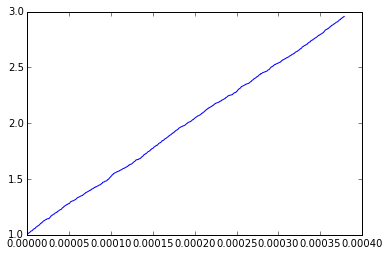

In [4]:
nX00 = nY00 = 1000
nX10 = nY10 = 2000
nZ00 = 0
nZ10 = 0
gamma0 = 5000
gamma1 = 50
gamma2 = 5 * 10**(-5)
gamma3 = 5
gamma = np.array([gamma0, gamma1, gamma2, gamma3])
V = 1
brus_n0 = np.array([nX00, nX10, nY00, nY10, nZ00, nZ10])

brus_nu0 = np.array([0, 0, +1, 0, 0, 0])
brus_nu1 = np.array([0, 0, 0, +1, +1, 0])
brus_nu2 = np.array([0, 0, +1, -1, 0, 0])
brus_nu3 = np.array([0, 0, -1, 0, 0, +1])
brus_nu = [brus_nu0, brus_nu1, brus_nu2, brus_nu3]
brus_t_max = 1000

def brus_calculate_r(brus_n, gamma, V):
    brus_r0 = gamma[0] * V * brus_n[0] #wieso hast du das hier so berechnet? wenn das so ist, wie im latexdkument geschrieben ist das doch nur gamma[0] 
    brus_r1 = gamma[1] * V**2 * brus_n[1] #und hier ist das doch mit brus_n[2]
    brus_r2 = gamma[2] * V**3 * 2 * brus_n[3] * brus_n[4] #
    brus_r3 = gamma[3] * V * brus_n[3] #hier müsste es brus_n[2] sein
    brus_r = [brus_r0, brus_r1, brus_r2, brus_r3]
    return brus_r

def reaction(V, brus_n0, brus_nu, gamma, brus_t_max):
    brus_t = 0
    brus_n = brus_n0

    for i in range(2000): # kann es sein, dass du das i gar nicht weiter genutzt hast?
        brus_r = brus_calculate_r(brus_n, gamma, V)
        brus_r_tot = sum(brus_r)
        if brus_r_tot==0: # das brus_r_tot kann doch gar nicht null werden... wir haben doch immer X_0 und X_1
            break
        brus_dt = np.random.uniform()
        brus_dt = 1/brus_r_tot * np.log(1/brus_dt)
        brus_t = brus_t + brus_dt
        brus_i = np.random.rand()
        brus_i = np.argmax(brus_i<np.cumsum(brus_r)/brus_r_tot)
        brus_n = brus_n + brus_nu[brus_i]
        yield brus_t, brus_n
        
brus_t, brus_n = zip(*list(reaction(V, brus_n0, brus_nu, gamma, brus_t_max)))
brus_n = np.array(brus_n).T
brus_t = np.array(brus_t)
plot(brus_t, brus_n[2] / brus_n0[2], label="Simulation $y_0$")
#plot(brus_t, brus_n[3] / brus_n0[3], 'r', label="Simulation $y_1$")

Nun fuehren wir neue Systemparameter ein. Neben dem Volumen V
betrachten wir auch die inverse Konzentration $\alpha = \frac{2k_3}{k_1x_1}$
der Resource $X_1$ sowie das Verhaeltnis $p = \frac{k_2k_0^2 x_0^2}{k_3^2 k_1x_1}$. 
- Wie lauten $\alpha$ und $p$ als Funktionen von $\gamma_0$, $\gamma_1$, $\gamma_2$ und $\gamma_3$? Wie lauten $\gamma_0$ und $\gamma_1$ als Funktionen von $\alpha$, $p$, $\gamma_2$ und $\gamma_3$? 

Haelt man $\alpha$ und $p$ konstant, so aendern sich mit dem Volumen nur die Teilchenzahlen, aber nicht die Konzentrationen. Haelt man hingegen $V$ und $p$
konstant, so durchlaeuft das System eine sogenannte Hopf-Bifurkation bei $\alpha = 2(1 − p)$. Fuer
kleinere Werte exisitert ein stabiles Gleichgewicht und fuer groeßere Werte faengt das System
an, um dieses Gleichgewicht zu oszillieren. 
- Ausgehend von den Werten $\gamma_0 \dots \gamma_3$ im Artikel [2],
Simulieren Sie das stochastische System bei konstanten $p$, $\gamma_2$ und $\gamma_3$ fuer verschiedene Werte
von $\alpha$ und beschreiben Sie Ihre Beobachtungen. 
- Fuer $\alpha = 0.5$ halten Sie nun $\alpha$, $p$, $\gamma_1$ und $\gamma_3$ konstant und veraendern Sie das Volumen $V$ indem Sie es mit einem Faktor $0 < \mu < 1$ multiplizieren. Was beobachten Sie fuer kleine $\mu$? (Verwenden Sie die Groessen $N_Y /\mu$ in den entsprechenden Plots). 

**Zusatzaufgabe :** 
- Zeigen Sie, dass $p = y_0^*/y_1^*$ gleich dem Verhaeltnis der Gleichgewichtskonzentrationen der Stoffe $Y_0$ und $Y_1$ ist. Im Gleichgewicht sind die Zeitableitungen Null. 
- Loesen sie das System von Differentialgleichungen fuer die mittleren Teilchenzahlen numerisch (z.B. mit Hilfe der Euler-Methode) bei ausgewaehlten Parametern, und vergleichen Sie diese deterministische Simulation
mit einer stochastischen Simulation mit denselben Parametern.

**Zusatzaufgabe :** 
- Entwerfen Sie eine Python Datenstruktur, welche beliebige Systeme von Reaktionen beschreiben kann und schreiben Sie Funktionen, welche diese Reaktionen fuer gegebene Teilchenanzahlen simulieren und die Simulationsergebnisse grafisch ausgeben koennen.

### Literatur :
[1] D. T. Gillespie, A General Method for Numerically Simulating the Stochastic Time
Evolution of Coupled Chemical Reactions, J. Comp. Phys. 22 4, (1976)

[2] D. T. Gillespie, Exact Stochastic Simulation of Coupled Chemical Reactions, J. Phys.
Chem. 81 25, (1977)

### Der Gillespie Algorithmus zur Simulation von Ratenuebergaengen :

Kann ein System aus einem Zustand $\alpha$ ueber verschiedene Wege $R_{i= 0 \dots (k − 1)}$ in verschiedene
Zustaende $\omega_i$ uebergehen, und sind die Raten $r_i$ der Uebergaenge bekannt, so ist die
Gesamtrate $r$, mit der der Zustand $\alpha$ verlassen wird gleich der Summe der einzelnen Raten
$r = \sum_{i=0}^{k-1} r_i$. Hierbei wird implizit angenommen, dass das System durch eine Ratengleichung
beschrieben werden kann, was im allgemeinen der Fall ist, wenn die Zeit zwischen den
Uebergaengen groß ist im Vergleich zu der Zeit, die das System braucht, um nach einer Reaktion
wieder das thermische Gleichgewicht zu erreichen. Die Zeit $\tau_\alpha$, die das System im Zustand $\alpha$
verbringt, ist exponentiell verteilt mit Wahrscheinlichkeitsdichte $p(\tau) = r exp(−r\tau)$. Verlaesst
das System den Zustand $\alpha$ nach der zufaelligen Verweildauer $\tau_\alpha$, so geschieht dies ueber einen
der moeglichen Reaktionswege $R_i$ mit einer Wahrscheinlichkeit $p_i = r_i/r$, also proportional zu
$r_i$. Der Gillespie Algorithmus erzeugt eine Zufallsfolge von Zustaenden $\alpha_n$ und Verweildauern $\tau_n$.

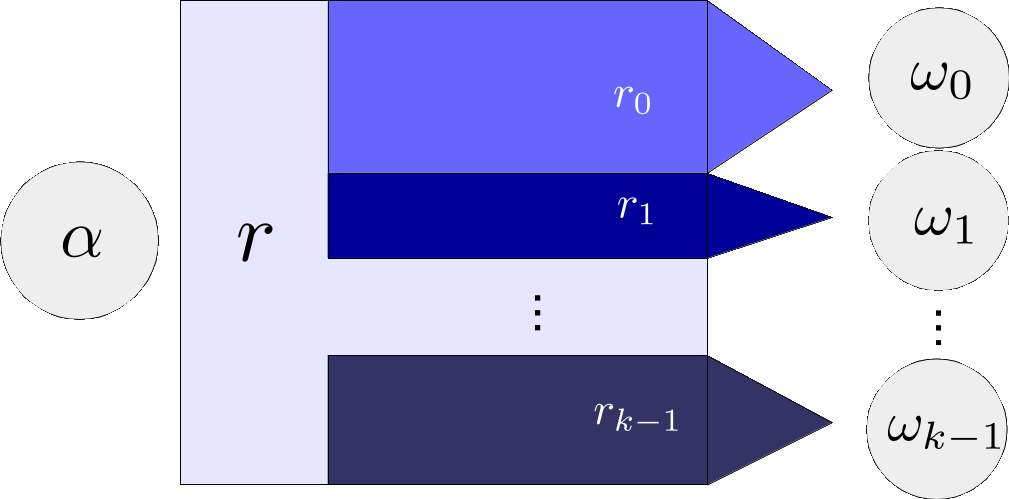

In [3]:
from IPython.display import Image
Image(filename="./TransitionRates.png", width=430)

### Von Reaktionsraten und Uebergangsraten :

Wir wollen nun chemische Reaktionen mit $\sigma = 0 \dots (n − 1)$ verschiedenen Teilchensorten
$A_\sigma$ betrachten, von denen jeweils $N_\sigma$ Teilchen vorhanden sind, und die eine Konzentration
$a_\sigma = N_\sigma/V$ haben. Der Zustand $\alpha$ in einem homogen gemischten System chemischer Reaktionen
wird zu jedem Zeitpunkt durch einen Vektor $\vec{N}$ von Teilchenzahlen bzw. Stoffkonzentrationen
$\vec{a}$ beschrieben. Die Zeitableitung der Stoffkonzentrationen ist in gewisser Naeherung
(siehe chemische Kinetik) proportional zur Konzentration jedes einzelnen der an einer Reaktion
beteiligten Reaktionspartner, sowie zur Differenz der stoechiometrischen Konstanten eines
Stoffes auf der linken und rechten Seite einer Reaktionsgleichung. Der Proportionalitaetsfaktor
$k_i$ fuer eine Reaktion $R_i$ wird auch als Reaktionsrate bezeichnet. Existieren mehrere Reaktionswege
fuer einen Stoff, so summieren sich deren Beitraege zur Zeitableitung. Die Kinetik einer
Reaktion 

$$
R_0 : m_0A_0 + m_1A_1 \to n_0A_0 + n_1A_1 
$$

mit Reaktionsrate $k_0$ wird zum Beispiel durch die Differentialgleichungen

$$
\begin{eqnarray}
    \frac{d}{dt}a_0 &=& k_0(n_0-m_0) a_0^{m_0}a_1^{m_1} \\
    \frac{d}{dt}a_1 &=& k_0(n_1-m_1) a_0^{m_0}a_1^{m_1}
\end{eqnarray}
$$

beschrieben. Man erhaelt Ratengleichungen fuer die *mittlere* Anzahl von Teilchen, wenn man
die $a_\sigma$ durch $N_\sigma/V$ ersetzt, und die Differentialgleichungen fuer die Konzentrationen mit dem
Volumen des Systems multipliziert. Fuer das Beispiel der Reaktion $R_0$ wuerden die mittleren
Teilchenzahlen durch die Gleichungen

$$
\begin{eqnarray}
    \frac{d}{dt}N_0 &=& V^{1-m_0-m_1}k_0(n_0-m_0) N_0^{m_0}N_1^{m_1} \\
    \frac{d}{dt}N_1 &=& V^{1-m_0-m_1}k_0(n_1-m_1) N_0^{m_0}N_1^{m_1}
\end{eqnarray}
$$

beschrieben. Die Uebergangsrate $r_0\left(\vec{N} ,\vec{k}, V\right)$ fuer diesen Reaktionsweg lautet 

$$
    r_0 = V^{1-m_0-m_1} k_0 N_0\cdot(N_0-1)\cdot\dots\cdot(N_0-m_0+1)\cdot N_1\cdot(N_1-1)\cdot\dots\cdot(N_1-m_1+1)
$$

und die Teilchenzahlen $N_\sigma$ aendern sich bei jedem Uebergang um die Differenz $(n_\sigma −m_\sigma)$. Die
etwas kompliziertere Form in der die Potenzen der Teilchenzahlen vorkommen kann man aus
einem Urnen-Modell herleiten. Wenn zwei Teilchen einer Sorte $\sigma$ miteinander reagieren, so
gibt es $N_\sigma(N_\sigma − 1)/2$ Moeglichkeiten hierfuer. Reagieren $m_\sigma$ Teilchen einer Sorte miteinander, so gibt es $\frac{N_\sigma!}{(N_\sigma-m_\sigma)!m_\sigma!}$ Moeglichkeiten, wobei der Divisor $m_\sigma!$ in die Reaktionskonstante absorbiert wird.